In [2]:
import pandas as pd

vivit_metrics = pd.read_csv("vivit_metrics_new/vivit_validation_metrics_all_runs.csv")
vivit_metrics.fillna(0, inplace=True)

vivit_precision_metrics = vivit_metrics[vivit_metrics["Metric"] == "Precision"]
vivit_recall_metrics = vivit_metrics[vivit_metrics["Metric"] == "Recall"]
vivit_accuracy_metrics = vivit_metrics[vivit_metrics["Metric"] == "Accuracy"]

convnext_metrics = pd.read_csv("convnext_metrics_new/convnext_validation_metrics_all_runs.csv")
convnext_metrics.fillna(0, inplace=True)

convnext_precision_metrics = convnext_metrics[convnext_metrics["Metric"] == "Precision"]
convnext_recall_metrics = convnext_metrics[convnext_metrics["Metric"] == "Recall"]
convnext_accuracy_metrics = convnext_metrics[convnext_metrics["Metric"] == "Accuracy"]

In [3]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import numpy as np
import pingouin as pg
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap


def interpret_pvalue(pvalue: float, threshold: float = 0.05) -> str:
    """Interpret p-value against significance threshold"""
    return "PASSED" if pvalue > threshold else "FAILED"


def check_normality(metric_name: str, values: np.ndarray) -> None:
    """Test and interpret normality for a given metric"""
    statistic, pvalue = shapiro(values)
    result = interpret_pvalue(pvalue)
    print(f"{metric_name:10} {result:8} (p={pvalue:.4f})")
    if result == "FAILED":
        print(f"          WARNING: {metric_name} is not normally distributed!")


def check_equal_variances(
    sample1: np.ndarray,
    sample2: np.ndarray,
    metric_name : str,
) -> None:
    """Test and interpret equality of variances across metrics"""
    statistic, pvalue = levene(sample1, sample2)
    result = interpret_pvalue(pvalue)
    print(f"{metric_name:10} {result:8} (p={pvalue:.4f})")
    if result == "FAILED":
        print(f"          WARNING: {metric_name} have significantly different variances!")

def check_ttest(
    sample1: np.ndarray,
    sample2: np.ndarray,
    metric_name: str,
    equal_var: bool = True
) -> None:
    """
    Perform and interpret an independent t-test for two samples.
    """
    statistic, pvalue = ttest_ind(sample1, sample2, equal_var=equal_var)
    result = interpret_pvalue(pvalue)
    print(f"{metric_name:10} {result:8} (p={pvalue:.4f}, t={statistic:.4f})")
    if result == "FAILED":
        print(f"          WARNING: Significant difference in means for {metric_name}!")

def check_mannwhitneyu(
    sample1: np.ndarray,
    sample2: np.ndarray,
    metric_name: str
) -> None:
    """
    Perform and interpret a Mann-Whitney U test for two samples.
    """
    statistic, pvalue = mannwhitneyu(sample1, sample2, alternative='two-sided')
    result = interpret_pvalue(pvalue)
    print(f"{metric_name:10} {result:8} (p={pvalue:.4f}, U={statistic:.4f})")
    if result == "FAILED":
        print(f"          WARNING: Significant difference in medians for {metric_name}!")

def check_ttest_power(
    sample1: np.ndarray,
    sample2: np.ndarray,
    metric_name: str
) -> None:
    """
    Perform t test power for two samples.
    """
    effect_size = pg.compute_effsize(sample1, sample2, eftype='cohen')
    power = pg.power_ttest(d=effect_size, n=10, alpha=0.5)
    
    print(f"{metric_name:10} {power:.4f}")


# Statistics

## Normality

### Vivit

In [4]:
# Vivit
vivit_accuracy_values = vivit_accuracy_metrics["Value"].astype(float)
vivit_recall_values = vivit_recall_metrics["Value"].astype(float)
vivit_precision_values = vivit_precision_metrics["Value"].astype(float)

print("\nNormality Tests (Shapiro-Wilk):")
print("-" * 40)
check_normality("Accuracy", vivit_accuracy_values)
check_normality("Recall", vivit_recall_values)
check_normality("Precision", vivit_precision_values)


Normality Tests (Shapiro-Wilk):
----------------------------------------
Accuracy   PASSED   (p=0.2045)
Recall     PASSED   (p=0.9055)
Precision  PASSED   (p=0.9133)


### Convnext

In [5]:
# ConvNext
convnext_accuracy_values = convnext_accuracy_metrics["Value"].astype(float)
convnext_recall_values = convnext_recall_metrics["Value"].astype(float)
convnext_precision_values = convnext_precision_metrics["Value"].astype(float)

print("\nNormality Tests (Shapiro-Wilk):")
print("-" * 40)
check_normality("Accuracy", convnext_accuracy_values)
check_normality("Recall", convnext_recall_values)
check_normality("Precision", convnext_precision_values)


Normality Tests (Shapiro-Wilk):
----------------------------------------
Accuracy   PASSED   (p=0.0549)
Recall     PASSED   (p=0.1621)
Precision  FAILED   (p=0.0084)


## Variances

In [6]:
print("\nEquality of Variance Tests (Levene):")
print("-" * 40)

check_equal_variances(vivit_accuracy_values, convnext_accuracy_values, "Accuracy")
check_equal_variances(vivit_recall_values, convnext_recall_values, "Recall")
check_equal_variances(vivit_precision_values, convnext_precision_values, "Precision")


Equality of Variance Tests (Levene):
----------------------------------------
Accuracy   PASSED   (p=0.6906)
Recall     PASSED   (p=0.2486)
Precision  FAILED   (p=0.0170)


## T test

In [7]:
print("\nMean equality Tests (T Student):")
print("-" * 40)

check_ttest(vivit_accuracy_values, convnext_accuracy_values, "Accuracy")
check_ttest(vivit_recall_values, convnext_recall_values, "Recall")
check_ttest(vivit_precision_values, convnext_precision_values, "Precision", equal_var=False)

# Non parametric for precision
check_mannwhitneyu(vivit_precision_values, convnext_precision_values, "Precision")


Mean equality Tests (T Student):
----------------------------------------
Accuracy   FAILED   (p=0.0005, t=4.2054)
Recall     FAILED   (p=0.0000, t=7.8191)
Precision  PASSED   (p=0.6784, t=0.4256)
Precision  PASSED   (p=1.0000, U=50.0000)


## Power

In [8]:
print("\nT Test power:")
print("-" * 40)

check_ttest_power(vivit_accuracy_values, convnext_accuracy_values, "Accuracy")
check_ttest_power(vivit_recall_values, convnext_recall_values, "Recall")
check_ttest_power(vivit_precision_values, convnext_precision_values, "Precision")



T Test power:
----------------------------------------
Accuracy   0.9998
Recall     1.0000
Precision  0.5369


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#A5D8D6", "#5FB3AF", "#337F79", "#174E4C"]
colors = ["#64deaeff", "#67bcd6ff"]

cmap = LinearSegmentedColormap.from_list("BrainMap",colors)
                                                       
def create_metrics_boxplot(metrics: pd.DataFrame, name: str) -> None:
    """Create a box plot comparing accuracy, precision and recall"""
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 12

    plt.figure(figsize=(12, 8))

    unique_metrics = metrics["Metric"].nunique()
    palette = [cmap(i / (unique_metrics - 1)) for i in range(unique_metrics)]

    sns.boxplot(
        x="Metric",
        y="Value",
        hue="Metric",
        data=metrics,
        palette=palette,
        legend=False,
    )

    plt.title(f"Distribution of {name} Performance Metrics", pad=20, fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()

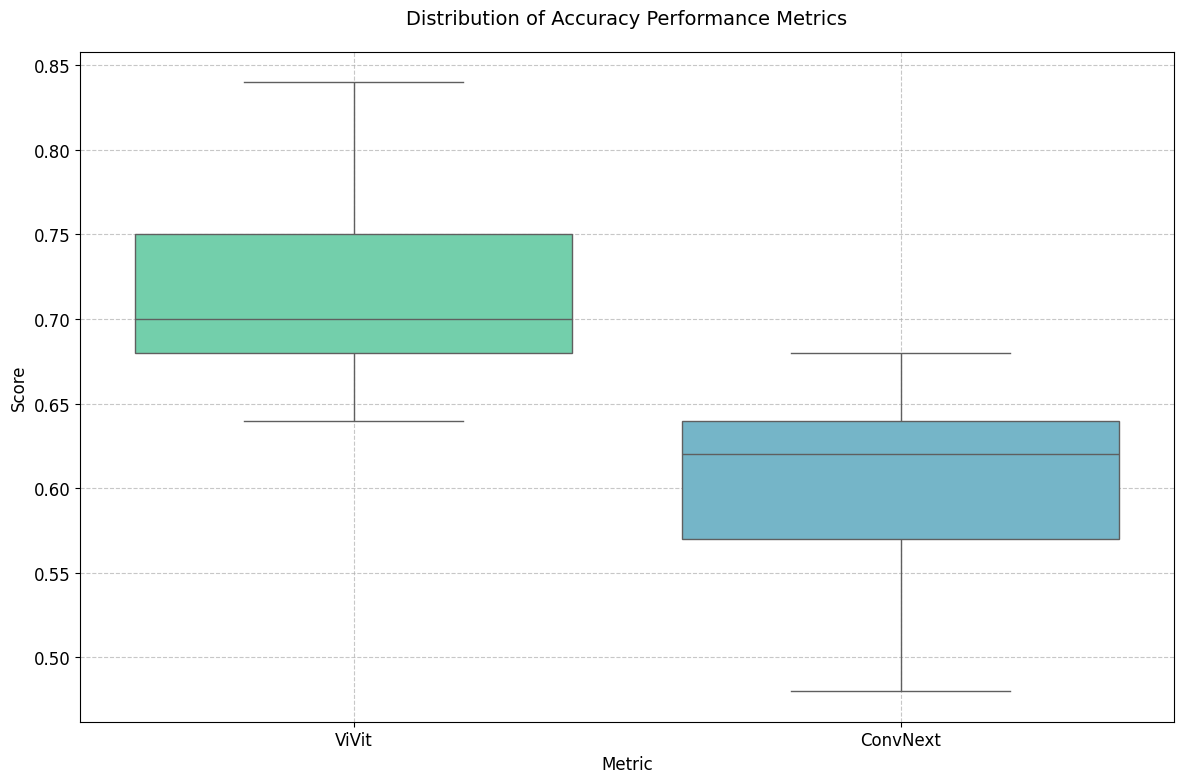

In [20]:
vivit_accuracy = vivit_metrics[vivit_metrics["Metric"] == "Accuracy"].reset_index(drop=True)
vivit_accuracy.loc[:, "Metric"] = vivit_accuracy["Metric"].replace("Accuracy", "ViVit")

convnext_accuracy = convnext_metrics[convnext_metrics["Metric"] == "Accuracy"].reset_index(drop=True)
convnext_accuracy.loc[:, "Metric"] = convnext_accuracy["Metric"].replace("Accuracy", "ConvNext")

accuracy = pd.concat([vivit_accuracy, convnext_accuracy]).reset_index(drop=True)
create_metrics_boxplot(accuracy, "Accuracy")

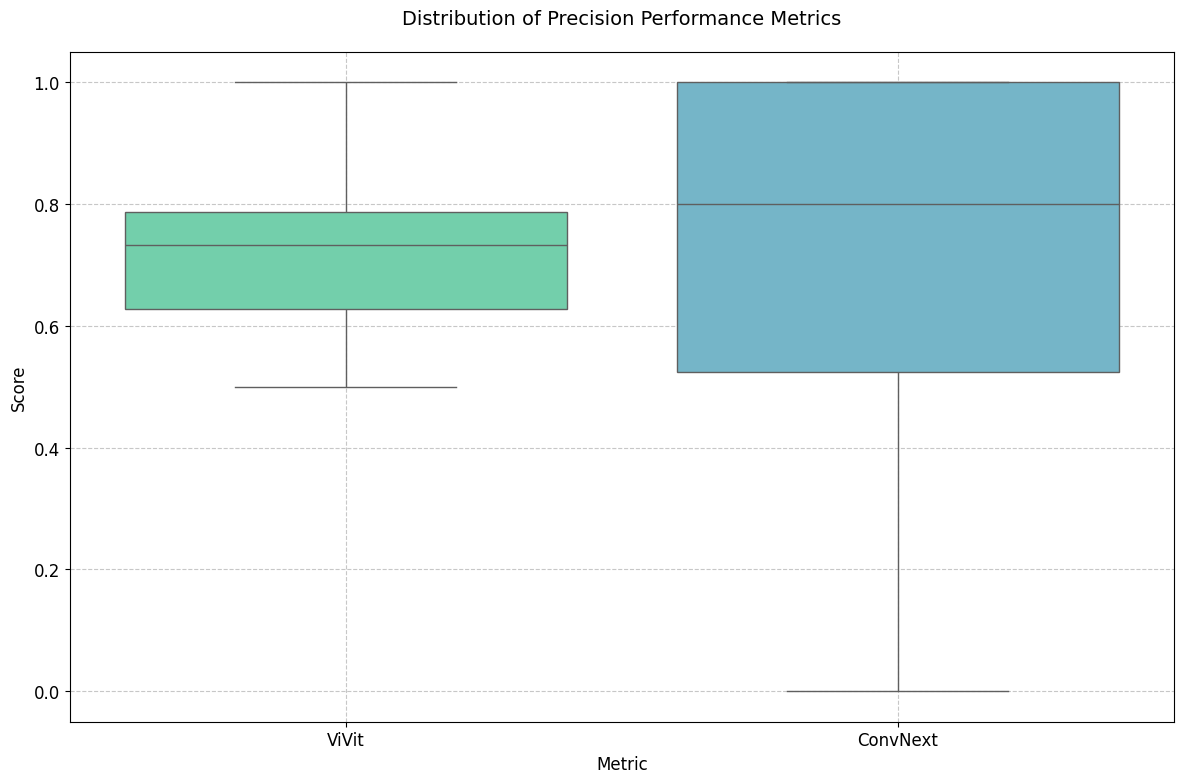

In [21]:
vivit_precision = vivit_metrics[vivit_metrics["Metric"] == "Precision"].reset_index(drop=True)
vivit_precision.loc[:, "Metric"] = vivit_precision["Metric"].replace("Precision", "ViVit")

convnext_precision = convnext_metrics[convnext_metrics["Metric"] == "Precision"].reset_index(drop=True)
convnext_precision.loc[:, "Metric"] = convnext_precision["Metric"].replace("Precision", "ConvNext")

precision = pd.concat([vivit_precision, convnext_precision]).reset_index(drop=True)
create_metrics_boxplot(precision, "Precision")

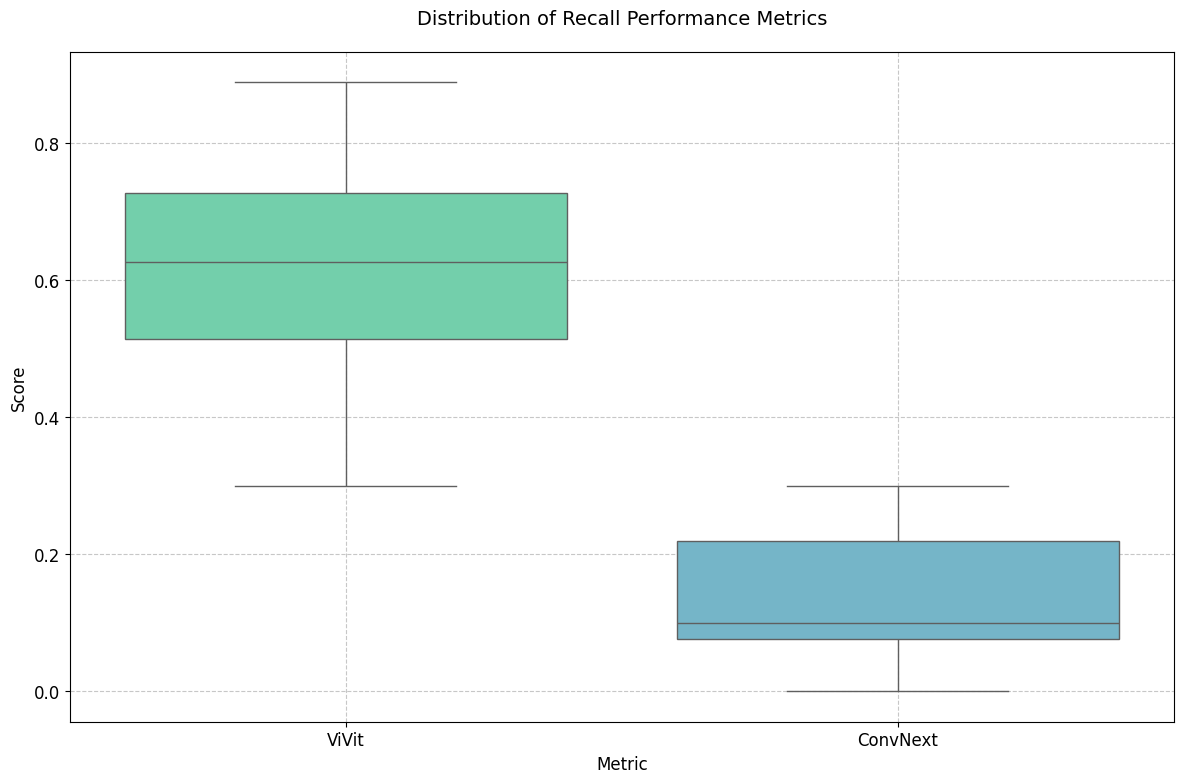

In [22]:
vivit_recall = vivit_metrics[vivit_metrics["Metric"] == "Recall"].reset_index(drop=True)
vivit_recall.loc[:, "Metric"] = vivit_recall["Metric"].replace("Recall", "ViVit")

convnext_recall = convnext_metrics[convnext_metrics["Metric"] == "Recall"].reset_index(drop=True)
convnext_recall.loc[:, "Metric"] = convnext_recall["Metric"].replace("Recall", "ConvNext")

recall = pd.concat([vivit_recall, convnext_recall]).reset_index(drop=True)
create_metrics_boxplot(recall, "Recall")

In [13]:
import os

def load_confusion_matrices(folder: str, model: str, num_runs: int = 10) -> pd.DataFrame:
    """Load and sum all confusion matrices from CSV files"""
    base_path = os.path.join(folder, f"{model.lower()}_cm_run_")
    cm = pd.read_csv(f"{base_path}0.csv")
    for i in range(1, num_runs):
        cm_path = f"{base_path}{i}.csv"
        cm = cm.add(pd.read_csv(cm_path), fill_value=0)

    return cm

def style_confusion_matrix() -> None:
    """Apply consistent styling to confusion matrix plots"""
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(10, 8))


def plot_confusion_matrix(cm: pd.DataFrame, title: str, fmt: str = "d") -> None:
    """Create and display a confusion matrix heatmap"""
    style_confusion_matrix()
    cm.columns = ["Negative", "Positive"]
    cm.index = ["Negative", "Positive"]

    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, cbar=False)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()



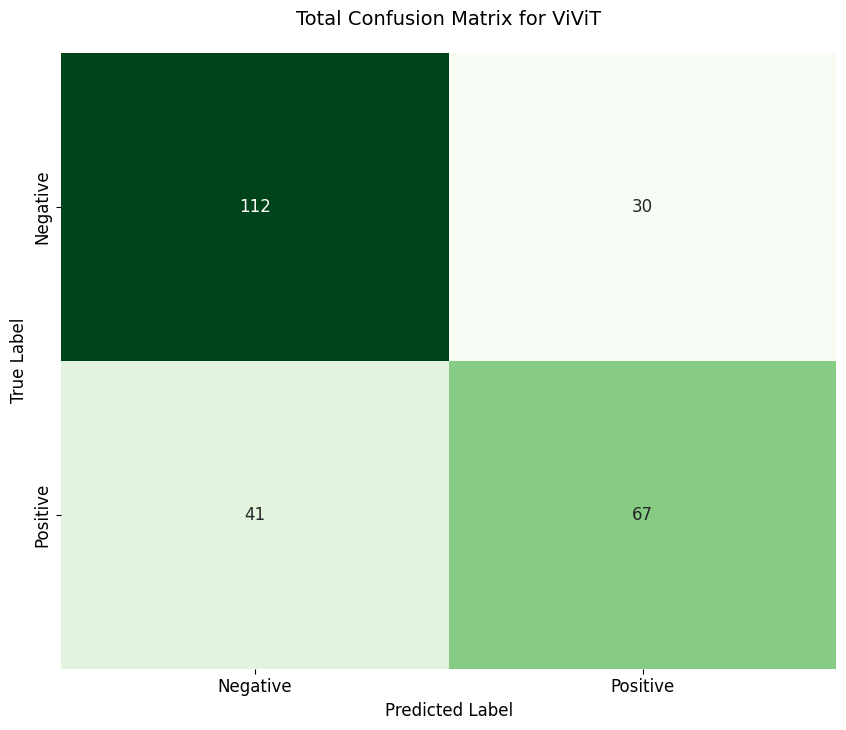

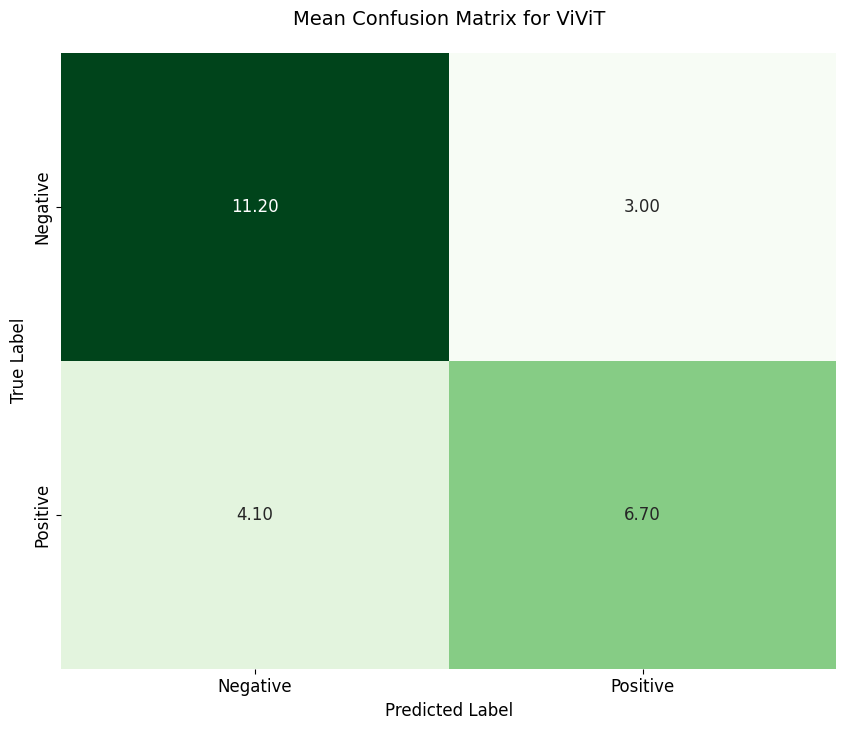

In [16]:
cmap = "Greens"

vivit_total_cm = load_confusion_matrices("vivit_metrics_new", model="vivit")
plot_confusion_matrix(vivit_total_cm, title="Total Confusion Matrix for ViViT")

mean_cm = vivit_total_cm / 10
plot_confusion_matrix(mean_cm, title="Mean Confusion Matrix for ViViT", fmt=".2f")

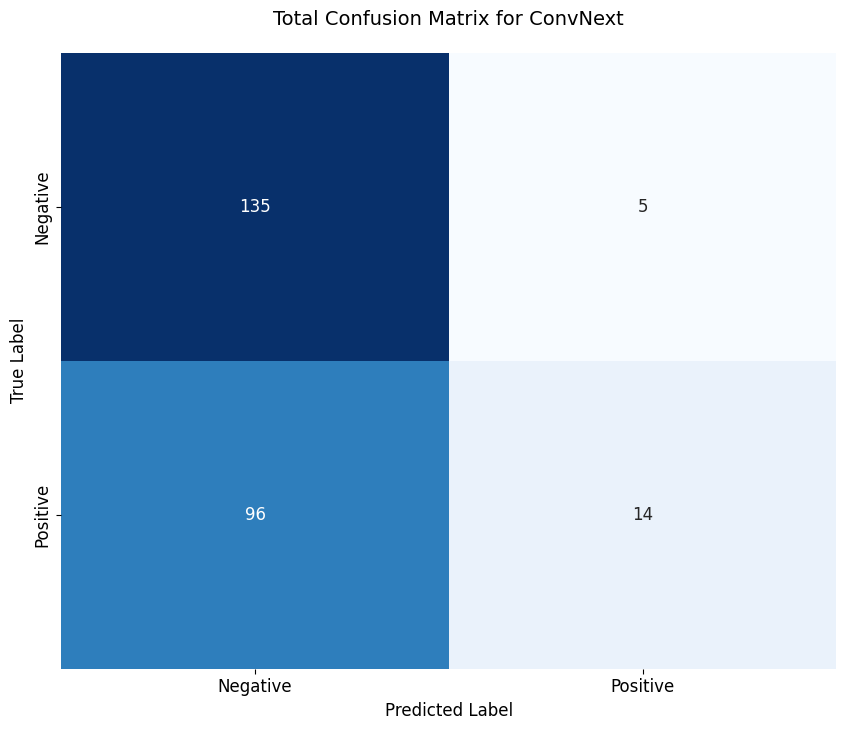

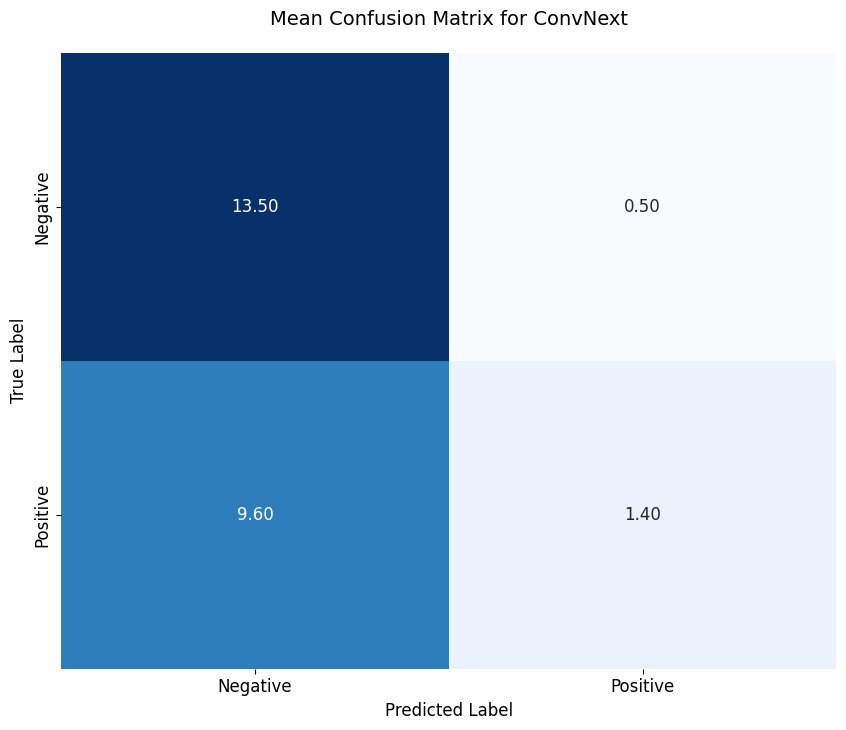

In [15]:
cmap = "Blues"
vivit_total_cm = load_confusion_matrices("convnext_metrics_new", model="convnext")
plot_confusion_matrix(vivit_total_cm, title="Total Confusion Matrix for ConvNext")

mean_cm = vivit_total_cm / 10
plot_confusion_matrix(mean_cm, title="Mean Confusion Matrix for ConvNext", fmt=".2f")